# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [12]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running the cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""
import importlib

import utils.finance.ticker_loader
importlib.reload(utils.finance.ticker_loader) # Sync changes in the module
from utils.finance.ticker_loader import TickerLoader

import utils.finance.finance_manager
importlib.reload(utils.finance.finance_manager) # Sync changes in the module
from utils.finance.finance_manager import StockCalculator

import utils.plots.stocks
importlib.reload(utils.plots.stocks) # Sync changes in the module
from utils.plots.stocks import StockPlotter

DATA_LOCATION = os.path.join(os.getcwd(), 'data/raw')


## Data Preprocessing Section

1. Download the data
2. Calculate Monthly Returns
3. Covariance Matrix

In [13]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL', 'NVDA', 'TSLA', 'UAA', 'SNAP', 'TEL.OL', 'MPCC.OL', 'AKAST.OL', 'BA', 'ADBE', 'ORCL', 'NTDOY', 'PCG', 'KHC', 'SONY']
print(f"Number of stocks: {len(STOCK_TICKERS)}")

Number of stocks: 20


## Processing[1] - Download Tickers.
*Downloads from Yahoo if there's any new tickers; else loads from 'data/raw/'*

In [14]:
ticker_data = TickerLoader.load(DATA_LOCATION, STOCK_TICKERS, **DATA_PERIOD)
ticker_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,25164.000000,25164.000000,25164.000000,25164.000000,2.516400e+04,25164.000000,25164.000000
mean,87.246373,88.418373,86.003576,87.227152,4.984328e+07,0.004112,0.002424
std,112.109571,113.548925,110.530662,112.070959,1.196938e+08,0.103731,0.188158
min,0.051421,0.052169,0.044129,0.047869,0.000000e+00,0.000000,0.000000
25%,10.893246,11.005998,10.751228,10.878897,1.864340e+06,0.000000,0.000000
50%,41.307612,41.779205,40.868024,41.343170,9.052850e+06,0.000000,0.000000
75%,128.033234,130.175314,125.987333,127.879944,3.620045e+07,0.000000,0.000000
max,696.280029,699.539978,678.909973,688.369995,2.511528e+09,5.000000,20.000000


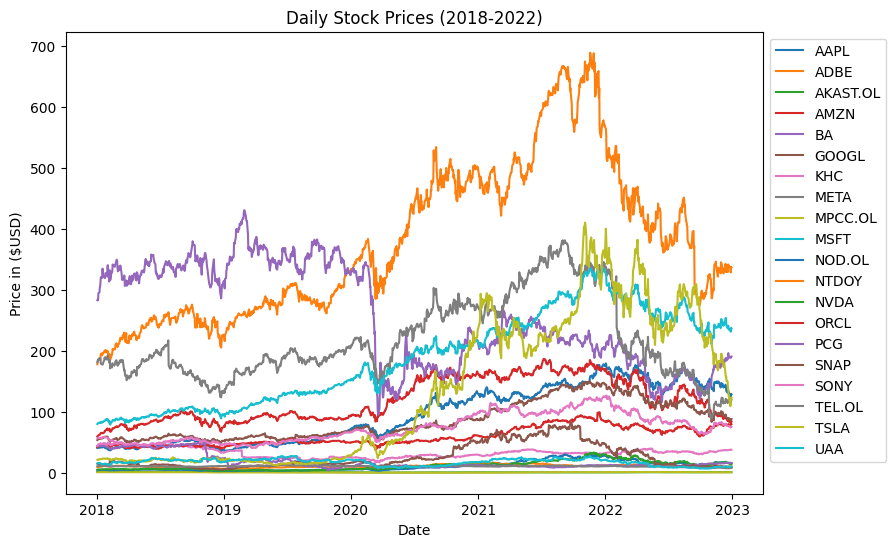

In [15]:
StockPlotter.stock_history(ticker_data, title='Daily Stock Prices (2018-2022)', ylabel='Price in ($USD)', column='Close')

In [16]:
ticker_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02,40.074355,40.578346,39.862394,40.568924,102223600,0.0,0.0,AAPL
2018-01-03,40.632513,41.108244,40.498274,40.561859,118071600,0.0,0.0,AAPL
2018-01-04,40.634874,40.853900,40.526541,40.750275,89738400,0.0,0.0,AAPL
2018-01-05,40.846823,41.301356,40.754975,41.214218,94640000,0.0,0.0,AAPL
2018-01-08,41.061150,41.357891,40.962232,41.061150,82271200,0.0,0.0,AAPL


## Processing [2] - Monthly Returns
*Calculating the monthly returns for all tickers into one dataframe*

In [17]:
monthly_returns_df = StockCalculator.monthly_returns(ticker_data)
monthly_returns_df.describe()

,Date,Close,Returns
count,1180,1180.000000,1180.000000
mean,2020-07-01 06:30:30.508474624,87.723685,0.274636
min,2018-02-01 00:00:00,0.077257,-125.969986
25%,2019-04-01 00:00:00,10.839147,-1.657000
50%,2020-07-01 00:00:00,41.211992,0.069127
75%,2021-10-01 00:00:00,128.956852,2.733346
max,2022-12-01 00:00:00,669.849976,112.839996
std,NaN,112.825482,15.045951


In [18]:
monthly_returns_df.head()

,Date,Ticker,Close,Returns
0,2018-02-01,AAPL,42.120049,2.688637
1,2018-03-01,AAPL,39.674957,-2.445091
2,2018-04-01,AAPL,39.079037,-0.595921
3,2018-05-01,AAPL,44.359558,5.280521
4,2018-06-01,AAPL,43.941772,-0.417786


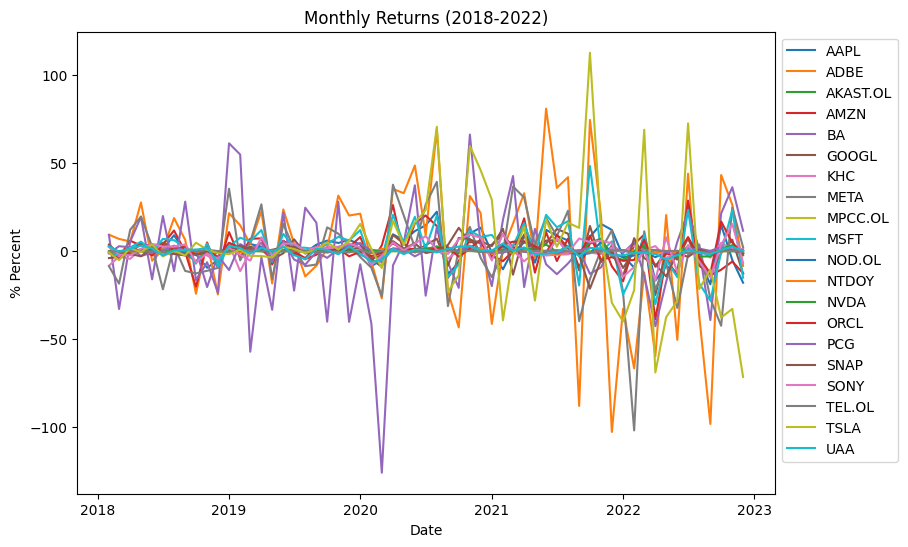

In [19]:
StockPlotter.stock_history(monthly_returns_df, title='Monthly Returns (2018-2022)', ylabel='% Percent', column='Returns')

## Processing [3] - Covariance Matrix

### Processing [3.1] - Calculate Covariance Matrix
*Calculating the covariance matrix from the standardized monthly returns to assess the portfolio's risk*

In [20]:
covariance_matrix_df = StockCalculator.covariance_matrix(monthly_returns_df, column='Returns')
print(f"Covariance Matrix Shape: {covariance_matrix_df.shape}")
covariance_matrix_df.head()

Covariance Matrix Shape: (20, 20)


Ticker,AAPL,ADBE,AKAST.OL,AMZN,BA,GOOGL,KHC,META,MPCC.OL,MSFT,NOD.OL,NTDOY,NVDA,ORCL,PCG,SNAP,SONY,TEL.OL,TSLA,UAA
Ticker,,,,,,,,,,,,,,,,,,,,
AAPL,90.329935,232.047987,0.289176,76.517198,62.426616,38.837573,5.037934,104.653296,0.331063,91.382814,6.996922,1.956016,12.945629,23.739207,7.974002,3.047946,28.005118,-0.408598,196.250311,5.812937
ADBE,232.047987,1472.956533,0.629790,260.764641,336.762692,158.449995,0.927473,480.677342,1.191231,401.290891,29.700164,4.535764,60.002011,114.712849,17.299391,-1.840507,110.134800,0.310931,565.752294,33.204173
AKAST.OL,0.289176,0.629790,0.010826,0.130403,1.358141,0.126414,0.032595,0.270527,0.002558,0.090752,-0.001823,0.000449,0.031547,0.076629,0.176139,0.065608,0.120955,-0.011708,0.260606,0.065108
AMZN,76.517198,260.764641,0.130403,130.484493,45.999541,51.809017,3.833478,121.346888,0.355914,108.717928,7.934878,2.882653,17.088294,21.751010,0.028137,13.539854,32.362019,-1.210885,230.013560,8.414253
BA,62.426616,336.762692,1.358141,45.999541,957.278574,54.698039,4.575140,153.366720,0.672676,104.289967,7.671264,3.820565,10.799737,56.087180,11.228795,16.758716,63.139923,0.384206,71.193871,28.866032


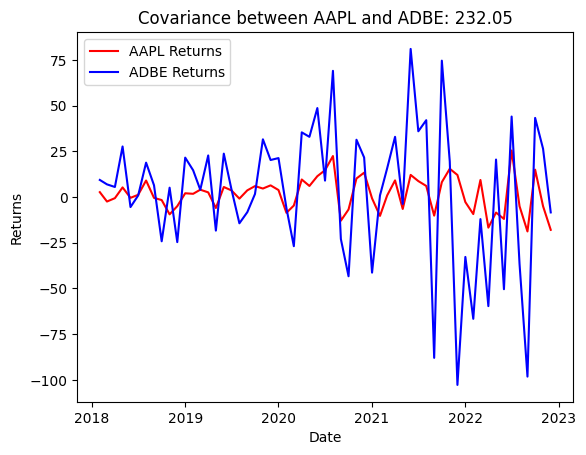

In [21]:
aapl = monthly_returns_df[monthly_returns_df['Ticker'] == 'AAPL']
abde = monthly_returns_df[monthly_returns_df['Ticker'] == 'ADBE']
covariance = np.cov(aapl['Returns'], abde['Returns'])[0, 1]

plt.plot(aapl['Date'], aapl['Returns'], label='AAPL Returns', color='red')
plt.plot(abde['Date'], abde['Returns'], label='ADBE Returns', color='blue')
plt.title(f'Covariance between AAPL and ADBE: {covariance:.2f}')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Processing [4] - Summary

We've downloaded 20 different stocks from Yahoo Finance and merged them into one dataframe. This enabled us to easily create a new dataframe of all the monthly returns for all stocks.
The monthly returns was then standardized.

We then used that monthly returns dataframe to calculate the covariance matrix.

The covariance matrix is an vector of $x \in \mathbb{R}^2$ which means it fits the optimization tartets of ES.

The data is now ready to be used in the algorithms!

Generation: 0.
Generation: 1.
Generation: 2.
Generation: 3.
Generation: 4.
Generation: 5.
Generation: 6.
Generation: 7.
Generation: 8.
Generation: 9.
Generation: 10.
Generation: 11.
Generation: 12.
Generation: 13.
Generation: 14.
Generation: 15.
Generation: 16.
Generation: 17.
Generation: 18.
Generation: 19.
Generation: 20.
Generation: 21.
Generation: 22.
Generation: 23.
Generation: 24.
End Population Size: 2


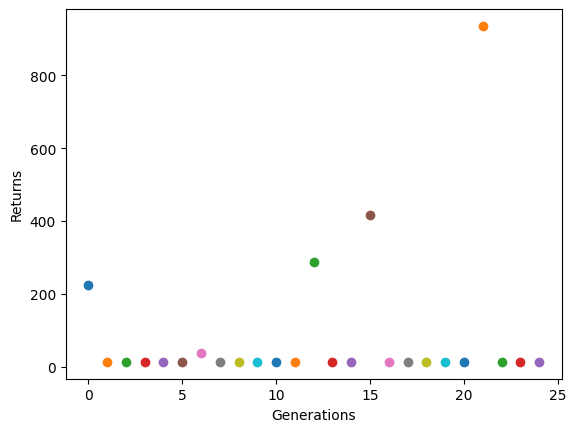

In [23]:
from strategies import basic_es as bes
from typing import List

class Logger(bes.ESLogger):
    def log(self, generation: int, rp: List[bes.RealRepresentation]) -> None:
        objs = [x.objectives for x in rp]
        returns = [(x * weights).sum() for x in objs]
        r = max(returns)
        plt.scatter(x = generation, y = r)
        plt.xlabel('Generations')
        plt.ylabel('Returns')

weights = np.array(monthly_returns_df.groupby('Ticker')['Returns'].sum().values)

basic = bes.ES() \
            .with_offsprings(7) \
            .with_population(20) \
            .with_mutation(rate=0.25) \
            .with_fitness(weights) \
            .with_generations(50) \
            .with_logger(Logger())

end_population = basic.run()
print(f"End Population Size: {len(end_population)}")

# basic = bes.BasicES(monthly_returns_df, 20, 1, 1, 0.25)
# basic()